# sentinelsat

In [7]:
# see https://sentinelsat.readthedocs.io/en/stable/index.html
# and the Sentinel user guide at https://sentinels.copernicus.eu/web/sentinel/user-guides

!pip install --user sentinelsat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 126.1 MB/s eta 0:00:0000:0100:01
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# connect to the OData API
#
# save credentials for scihub.copernicus.eu in $HOME/.netrc like this:
#
# machine scihub.copernicus.eu
#   login <your username>
#   password <your password>
# machine colhub.met.no
#   login <your username>
#   password <your password>
#
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

local_api = SentinelAPI(None, None, "https://colhub.met.no")
api = SentinelAPI(None, None, "https://scihub.copernicus.eu/dhus")

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

In [2]:
# get full metadata for a specific product
api.get_product_odata('04548172-c64a-418f-8e83-7a4d148adf1e', full=True)

{'id': '04548172-c64a-418f-8e83-7a4d148adf1e',
 'title': 'S1A_IW_SLC__1SDV_20170425T155612_20170425T155639_016302_01AF91_46FF',
 'size': 4633501134,
 'md5': 'e5855d1c974171d33ee4bc08b9d221ae',
 'date': datetime.datetime(2017, 4, 25, 15, 56, 12, 814000),
 'footprint': 'POLYGON((34.322010 0.401648,36.540989 0.876987,36.884121 -0.747357,34.664474 -1.227940,34.322010 0.401648))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('04548172-c64a-418f-8e83-7a4d148adf1e')/$value",
 'Online': False,
 'Creation Date': datetime.datetime(2017, 4, 25, 19, 22, 0, 383000),
 'Ingestion Date': datetime.datetime(2017, 4, 25, 19, 23, 45, 956000),
 'Acquisition Type': 'NOMINAL',
 'Carrier rocket': 'Soyuz',
 'Cycle number': 107,
 'Date': datetime.datetime(2017, 4, 25, 15, 56, 12, 814000),
 'Filename': 'S1A_IW_SLC__1SDV_20170425T155612_20170425T155639_016302_01AF91_46FF.SAFE',
 'Footprint': '<gml:Polygon srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" xmlns:gml="http://www.opengis.net/gml"

In [2]:
# NOTE: Test data - overwritten by next cell

# Spatial locations
locations = [[4.4, 60.3],
             [3.4, 60.3],
             [3.4, 65.7]]

footprint_json = {
  "type": "Feature",
  "geometry": {
    "type": "MultiPoint",
    "coordinates": locations
  }
}
footprint = geojson_to_wkt(footprint_json)

# Time interval
start_times = "2022-09-25T00:00:00.000Z"
end_times = "2022-09-26T23:59:59.000Z"

In [13]:
# import dict containing metadata for in-situ data
# https://raw.githubusercontent.com/jerabaul29/MachineOcean_WP1_WHOI/main/mo_whoi_data/data_files/in_situ_dict.py
# from private repo at https://github.com/jerabaul29/MachineOcean_WP1_WHOI
import time
import os

os.environ["TZ"] = "UTC"
time.tzset()

import datetime
import pytz

utc_timezone = pytz.timezone("UTC")

import sys
sys.path.append("../../MachineOcean_WP1_WHOI/mo_whoi_data/data_files")

import in_situ_dict
in_situ_obs = in_situ_dict.get_in_situ_metadata()

# make list of in-situ locations to fetch sat data for, including start_time and end_time for each location timeseries
locations = []
start_times = []
end_times = []

for obs in in_situ_obs.values():
    locations.append([obs["lon"][0], obs["lat"][0]])
    start_times.append(obs["datetime_start"])
    end_times.append(obs["datetime_end"])

In [12]:
# search by polygon, time, and SciHub query keywords - build dict with all relevant sat products
products = {}
for (location, start_time, end_time) in zip(locations, start_times, end_times):
    footprint_json = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": location
      }
    }
    footprint = geojson_to_wkt(footprint_json)

    products.update(api.query(footprint,
                        date=(start_time, end_time),
                        platformname="Sentinel-1",
                        producttype="GRD"))
                        #limit=1,
                        #cloudcoverpercentage=(0, 30)))

print("Sat products: " + str(len(products)))

print(products.keys())

raise

# are the products online or offline?
for product_id in list(products.keys()):
    if api.is_online(product_id):
        print("Product {} is online. Will download.".format(product_id))
    else:
        print("Product {} is offline. Will NOT download.".format(product_id))
        del products[product_id]
        #print(("Product {} is offline. Retrieval is triggered.".format(product_id))
        #api.trigger_offline_retrieval(product_id)

Querying products:  25%|##5       | 100/396 [00:00<?, ?product/s]

Querying products:  30%|###       | 100/331 [00:00<?, ?product/s]

Sat products: 937
dict_keys(['ba781da2-8040-412f-a9b2-60215b5e45e1', '4cd3b915-769e-4bcb-9755-e2ba5d27d35e', '51ab49e6-d511-418f-8f16-8fecfa14a6e4', 'c8a84b40-a72b-4b2a-bd2d-6212acb70d17', '1f6b33ba-a1c7-424c-b74e-db9ff91280d4', 'ec26501b-3127-46ff-8020-1545fb50deee', '2ff135e0-6eb2-4292-b79f-c86d861387ec', '7f5df7d9-d23f-4142-8a59-226d27491d14', '88af7d15-85f2-4f2d-9f58-4f5f6af44a60', '9b21364c-e320-4c5e-8b5b-7eb8ab5d8b55', 'f11daa3c-7de8-43e7-a033-1d0dd8014cde', '504bdc20-90ed-492f-918d-73ab56c6f7c0', 'd05ace21-5b3d-44c9-9cf7-5ed31ad8bd07', 'a0ada644-0b02-4c24-a5c0-9cccaa896a2c', '9148710e-0b5e-42d8-8e12-d8403077da32', '925205c7-1b49-4d84-b657-03870093fbe1', 'ba2aaf6d-d00f-47a9-a14b-9a39c93eb44c', 'd284312c-f969-4f1f-8713-55652c814ed3', '0f86b245-1abc-4cdd-88e9-5b235728ab49', '45d06eac-64c6-47bc-bbb7-c01d370cb82b', '4b49eae2-4fac-4a70-89d1-fca3f78a3649', '304a738e-c999-4a6c-9ae6-639eb51185eb', 'ae6c76e3-61cb-4281-b9fb-d48795bd844f', '9256b869-78a0-4bbe-a72d-b266253e8ecc', 'e215715a-8

RuntimeError: No active exception to reraise

In [30]:
#path_filter = make_path_filter("*s1?-*-grd-vv-*.tiff")
path_filter = make_path_filter("*s1?-*-grd-*.tiff")
api.download_all(products, directory_path=data_dir)#, nodefilter=path_filter)

# convert to Pandas DataFrame
products_df = api.to_dataframe(products)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
products_geojson = api.to_geojson(products)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
products_gdf = api.to_geodataframe(products)

# Get basic information about the product: its title, file size, MD5 sum, date, footprint and
# its download url
#api.get_product_odata(<product_id>)

# Get the product's full metadata available on the server
#api.get_product_odata(<product_id>, full=True)

INFO:sentinelsat.SentinelAPI:Will download 3 products using 4 workers


MD5 checksumming:   0%|          | 0.00/6.80M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/849M [00:00<?, ?B/s]

In [31]:
products_gdf

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,missiondatatakeid,...,producttype,platformname,platformidentifier,instrumentname,instrumentshortname,productclass,polarisationmode,acquisitiontype,uuid,geometry
8ac69d93-ae92-4e8a-ae2e-0f3fd39dfdc9,S1A_IW_SLC__1SDV_20220925T171245_20220925T1713...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-09-25T17:12:45.475Z, Instrument: SA...",false,2022-09-25 17:12:45.475,2022-09-25 17:13:12.444,2022-09-25 18:20:17.266,353761,...,SLC,Sentinel-1,2014-016A,Synthetic Aperture Radar (C-band),SAR-C SAR,S,VV VH,NOMINAL,8ac69d93-ae92-4e8a-ae2e-0f3fd39dfdc9,"MULTIPOLYGON (((2.31903 64.73522, 7.76120 65.2..."
1ece2b95-c745-4a2c-9749-734c6641ab3c,S1A_IW_OCN__2SDV_20220925T171246_20220925T1713...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-09-25T17:12:46.147Z, Instrument: SA...",false,2022-09-25 17:12:46.147,2022-09-25 17:13:11.146,2022-09-25 18:16:43.381,353761,...,OCN,Sentinel-1,2014-016A,Synthetic Aperture Radar (C-band),SAR-C SAR,S,VV VH,NOMINAL,1ece2b95-c745-4a2c-9749-734c6641ab3c,"MULTIPOLYGON (((2.29733 64.77502, 7.80552 65.2..."
083721d8-2652-4ef4-bfcf-d73bacc737a2,S1A_IW_GRDH_1SDV_20220925T171246_20220925T1713...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-09-25T17:12:46.147Z, Instrument: SA...",false,2022-09-25 17:12:46.147,2022-09-25 17:13:11.146,2022-09-25 18:06:36.460,353761,...,GRD,Sentinel-1,2014-016A,Synthetic Aperture Radar (C-band),SAR-C SAR,S,VV VH,NOMINAL,083721d8-2652-4ef4-bfcf-d73bacc737a2,"MULTIPOLYGON (((2.29733 64.77502, 7.80531 65.2..."


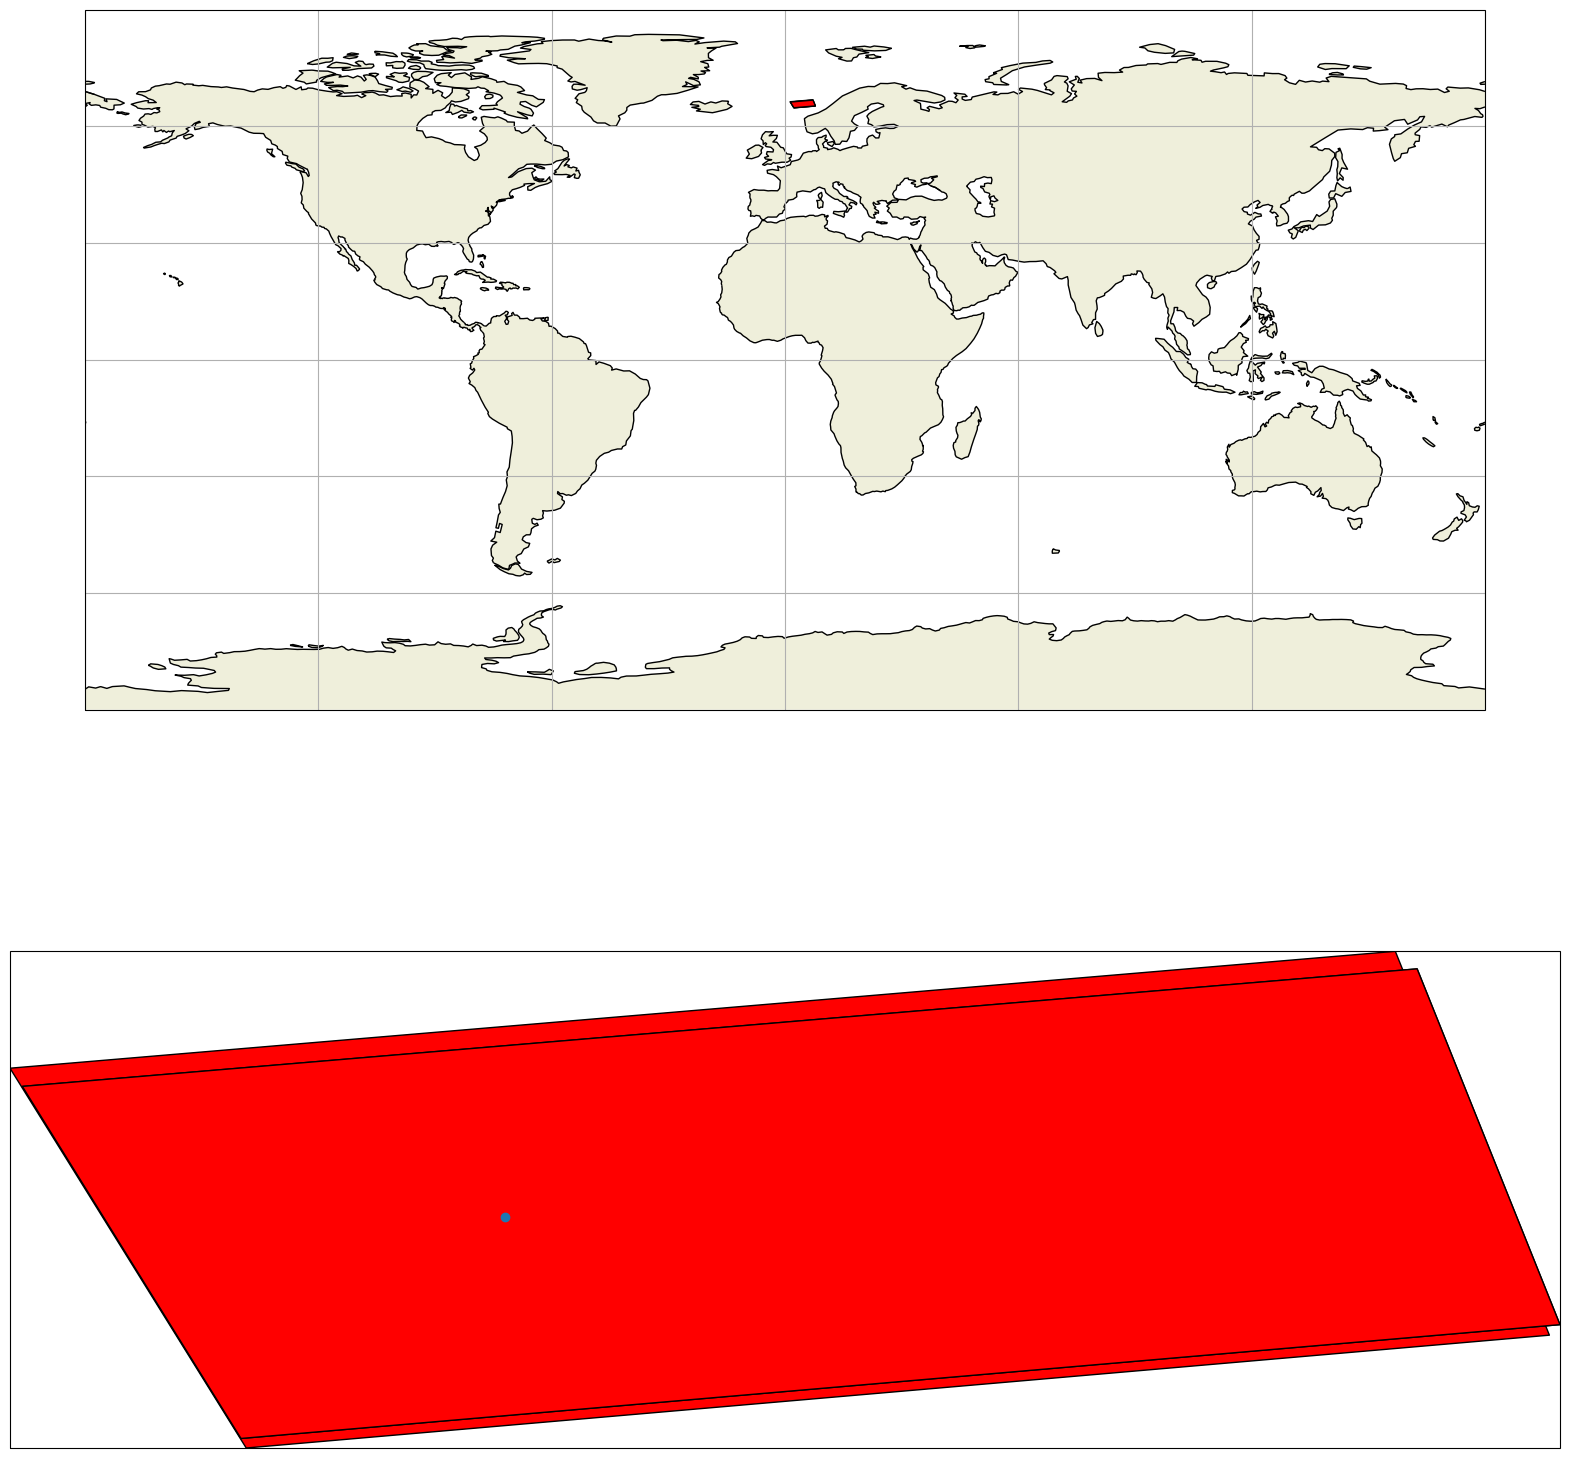

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import numpy as np

fig = plt.figure(figsize=(20, 20))

bounds = products_gdf.total_bounds

ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
ax2.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)

locations_np = np.array(locations)
locs_x, locs_y = locations_np.T
ax2.scatter(locs_x, locs_y, transform=ccrs.PlateCarree(), zorder=2)

plt.show()

# pytroll

In [2]:
# see http://pytroll.github.io/

!pip install --user satpy rioxarray rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 113.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Created wheel for satpy: filename=satpy-0.37.1-py2.py3-none-any.whl size=1308928 sha256=21b6993ee16ac37dea8383ffa54426f1e3eff2efef6b0c968ec4ea

In [3]:
from satpy.utils import check_satpy

check_satpy()

Readers
abi_l1b:  ok
abi_l1b_scmi:  ok
abi_l2_nc:  ok
acspo:  ok
agri_l1:  ok
ahi_hrit:  ok
ahi_hsd:  ok
ahi_l1b_gridded_bin:  ok
ami_l1b:  cannot find module 'satpy.readers.ami_l1b' (No module named 'pyspectral')
amsr2_l1b:  ok
amsr2_l2:  ok
amsr2_l2_gaasp:  ok
amsub_l1c_aapp:  ok
ascat_l2_soilmoisture_bufr:  ok
avhrr_l1b_aapp:  ok
avhrr_l1b_eps:  ok
avhrr_l1b_gaclac:  cannot find module 'satpy.readers.avhrr_l1b_gaclac' (No module named 'pygac')
avhrr_l1b_hrpt:  cannot find module 'satpy.readers.hrpt' (No module named 'geotiepoints')
avhrr_l1c_eum_gac_fdr_nc:  ok
caliop_l2_cloud:  cannot find module 'satpy.readers.caliop_l2_cloud' (No module named 'pyhdf')
clavrx:  cannot find module 'satpy.readers.clavrx' (No module named 'pyhdf')
cmsaf-claas2_l2_nc:  ok
electrol_hrit:  ok
fci_l1c_nc:  ok
fci_l2_nc:  ok
generic_image:  ok
geocat:  ok
ghrsst_l2:  ok
glm_l2:  ok
goes-imager_hrit:  ok
goes-imager_nc:  ok
gpm_imerg:  ok
grib:  ok
hsaf_grib:  ok
hy2_scat_l2b_h5:  ok
iasi_l2:  ok
iasi_l2_s

In [15]:
from satpy import Scene, find_files_and_readers
from datetime import datetime
import zipfile
from os import path
import glob

for product_name in products_gdf.title:
    zip_filename = data_dir + "{}.zip".format(product_name)
    safe_dir_name = data_dir + "{}.SAFE".format(product_name)

    if not path.exists(safe_dir_name):
        with zipfile.ZipFile(zip_filename,"r") as zip_ref:
            zip_ref.extractall(data_dir)

In [27]:
import os
print(os.listdir(data_dir + "S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE"))

files = find_files_and_readers(
    base_dir=data_dir + "S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE",
    reader="sar-c_safe")

['S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE-report-20220925T180337.pdf', 'preview', 'support', 'manifest.safe', 'measurement', 'annotation']


ValueError: No supported files found

In [17]:
from satpy.dataset import DataQuery

scn = Scene(filenames=files)

scn.available_dataset_names()
scn.available_composite_names()

['sar-ice',
 'sar-ice-iw',
 'sar-ice-legacy',
 'sar-ice-log',
 'sar-ice-log-iw',
 'sar-land',
 'sar-land-iw',
 'sar-quick',
 'sar-rgb']

In [14]:
vh_id = DataQuery(name="measurement", polarization="vh")
scn.load([vh_id])
scn[vh_id]

ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found


<xarray.DataArray (y: 16678, x: 26733)>
dask.array<clip, shape=(16678, 26733), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) int64 0 1 2 3 4 5 6 ... 16672 16673 16674 16675 16676 16677
  * x            (x) int64 0 1 2 3 4 5 6 ... 26727 26728 26729 26730 26731 26732
    band         int64 1
    spatial_ref  int64 0
    crs          object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Attributes:
    name:                 measurement
    sensor:               sar-c
    wavelength:           [5.4, 5.405, 5.41]
    resolution:           80
    polarization:         vh
    calibration:          gamma
    quantity:             natural
    coordinates:          ('longitude', 'latitude')
    file_type:            safe_measurement
    standard_name:        backscatter
    units:                1
    modifiers:            ()
    platform_name:        s1b
    start_time:           2021-12-15 06:10:27
    end_time:             2021-12-15 06:10:52
    reader:               sar-c_safe
    area:                 Shape: (16678, 26733)\nLons: <xarray.DataArray 'int...
    _satpy_id:            DataID(name='measurement', polarization='vh', resol...
    ancillary_variables:  []

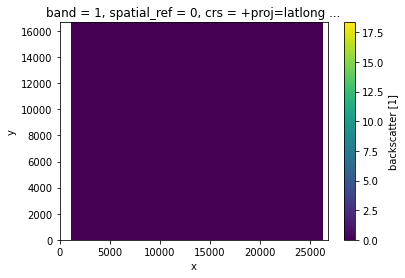

In [16]:
# To save as Geotiff (including the GCPs):
#scn.save_dataset(vh_id)

# XXX: Takes forever... investigate further
scn[vh_id].plot.imshow()

# XXX: Check out https://python-kurs.github.io/sommersemester_2019/units/S01E06.html 
# and https://nbviewer.org/github/pytroll/pytroll-examples/ ?